

Before
(30, 30)
[ 98  89  78 112  90  93 158 112 122 117 107 121  90  75  67  93  73  67
  96 152 167 151 166 154 134 105  53  51  55  44]


After
(30, 30)
[183 196  18 126 207  19 182 105   1  51 117  43 120 138 189  98 164 163
 108 248 225  40 229   7 249 226  46   9 241   2]

OUT01
[  83   -1   82  145  -22 -382 -133  -36 -197 -271 -281 -245 -314 -365
 -398 -347 -254 -193 -217 -147 -141 -168 -194 -120  -56   10  -67  -59]

OUT02
[[  83  145   -8  -36 -197 -245 -298 -247 -193 -147 -141  -62   10  -38]
 [  40   -8 -185 -161 -149 -186 -206 -118 -157   75 -123  -43   60  -48]
 [  -4  -66 -201 -100 -206 -125 -264 -159 -124   59  140 -157  -61   37]
 [  82  111  255 -246 -194  150  103  188  -70  -32  121  -51 -160   49]
 [ -17  -30   -7 -172 -137   51   10  -61   -2  122   -2   -4  -43 -117]
 [ -31 -133 -190  -55   61  -55  -11  160  -63   -4   23    8  -71  -75]
 [ -67    9   58 -120  -75  -58  -83  -60  -70   28  -32  -70  -24   65]
 [ 207   67   60 -194    4  -31  -63  -45  -46  -22

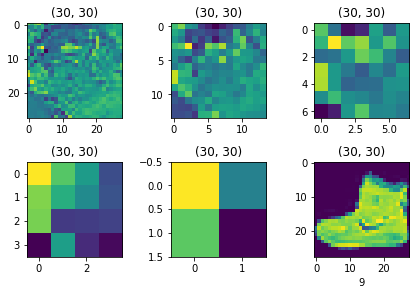

x_train shape:  (60000, 32, 32, 1)
60000 train samples
10000 test samples
Epoch 1/10
844/844 [==============================] - 31s 36ms/step - loss: 0.8374 - accuracy: 0.7036 - val_loss: 0.4412 - val_accuracy: 0.8490
Epoch 2/10
 97/844 [==>...........................] - ETA: 25s - loss: 0.4588 - accuracy: 0.8429

In [ ]:
#   All code was written by Steve Montes


# I know this is a lot of libraires but i tried a lot of ways to learn how to do 
#   this and see how it would come out
#import cv2 as cv
from scipy import ndimage, misc
from scipy.signal import convolve2d
import numpy as np
import imageio
from skimage import io, img_as_ubyte
from skimage.measure import block_reduce
from IPython.display import display, Image
import matplotlib.pyplot as plt 
from tensorflow import keras
from tensorflow.keras import layers
#import mnist_reader


# 1 - Basic Image Processing

# Display Image first and saving it under var I
img= img_as_ubyte(io.imread('./image.jpg', as_gray=False)) 
I = Image('./image.jpg')
display(I)

# Converting the image into an array 
#print(img_matrix)
print("\n\nBefore")
print(img.shape)
print(img[0])

# Laplacian kernel is defined as: K(x,y) = exp(-gamma ||x-y||_1)
## Convolution with Laplacian Filter ##
def conv_transform(image):
  image_copy = image.copy()

  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      image_copy[i][j] = image[image.shape[0]-i-1][image.shape[1]-j-1]
  return image_copy

def conv(image, kernel):
  #MUST BE GRAYSCALE
  kernel = conv_transform(kernel) # to differ it from corelation
  image_h = image.shape[0]
  image_w = image.shape[1]

  kernel_h = kernel.shape[0]
  kernel_w = kernel.shape[1]

  h = kernel_h//2
  w = kernel_w//2

  image_conv = np.zeros(image.shape)

  for i in range(h, image_h-h):
    for j in range(w, image_w-w):
      sum =0

      for m in range(kernel_h):
        for n in range(kernel_w):
          sum = sum + kernel[m][n]*image[i-h+m][j-w+n]

      image_conv[i][j] = sum
  return image_conv

LaplaceResult = ndimage.laplace(img)
#plt.imshow(LaplaceResult,cmap="viridis")
print("\n\nAfter")
print(LaplaceResult.shape)
print(LaplaceResult[0])

#define filter
LaplaceFilter = np.array([[0,1,0],
                          [0,-4,1],
                          [0,1,0]])

#apply filters                          
out01 = convolve2d(img,LaplaceFilter,mode="valid")
out02 = [out01]
for i in range(5):
  out02.append(block_reduce(out02[-1], (2, 2), np.max))

#Displaying Images
plt.subplot(131)
plt.title(img.shape)
plt.imshow(img, cmap="gray")

plt.subplot(132)
plt.title(out01.shape)
plt.imshow(out01, cmap="viridis")

for i in range (6):
  plt.subplot(231 + i)
  plt.title(img.shape)
  plt.imshow(out02[i], cmap="viridis")

plt.tight_layout()

print("\nOUT01")
print(out01[0])

print("\nOUT02")
print(out02[1])








# 2 - Convolution Neural Network
#tf.keras.datasets.mnist.load_data(path="mnist.npz")
#fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Model/Parameters
num_classes = 10
input_shape = (32,32,1) 

# Image Normalization
x_train = x_train.astype("float32") /255
x_test = x_test.astype("float32") / 255

# Print out first image and its corresponding label index
plt.imshow(x_train[0])
plt.xlabel(y_train[0])
plt.show()

# Dimension expansion to ensure that images have shape
x_train = np.expand_dims(x_train,-1)
x_test = np.expand_dims(x_test,-1)

# Conduct padding on training/test images
x_train = np.pad(x_train,((0,0),(2,2),(2,2),(0,0)), 'constant')
x_test = np.pad(x_test,((0,0),(2,2),(2,2),(0,0)), 'constant')

# Print out the training/test
print("x_train shape: ", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# Convert label vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Construct LeNet-5

from tensorflow.keras import regularizers
keras.backend.clear_session()

model = keras.Sequential(
    [
      keras.Input(shape = input_shape),
     layers.Conv2D(6, kernel_size=(5,5), kernel_regularizer=regularizers.l2(4e-5),activation="relu"),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Conv2D(16,kernel_size=(5,5),kernel_regularizer=regularizers.l2(4e-5),activation="relu"),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Flatten(),
     layers.Dense(120, kernel_regularizer=regularizers.l2(4e-5), activation="relu"),
     layers.Dense(84,kernel_regularizer=regularizers.l2(4e-5), activation = "relu"),
     layers.Dense(10, activation="softmax")
     ]
    )

#model.summary()

# Train SGD
batch_size = 64
epochs = 10
sgd = keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs = epochs, validation_split=0.1)

# Print out the evaluation results
score = model.evaluation(x_test,y_test,verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score)

# For Batch Size = 128 
keras.backend.clear_session()

model = keras.Sequential(
    [
      keras.Input(shape = input_shape),
     layers.Conv2D(6, kernel_size=(5,5), kernel_regularizer=regularizers.l2(4e-5),activation="relu"),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Conv2D(16,kernel_size=(5,5),kernel_regularizer=regularizers.l2(4e-5),activation="relu"),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Flatten(),
     layers.Dense(120, kernel_regularizer=regularizers.l2(4e-5), activation="relu"),
     layers.Dense(84,kernel_regularizer=regularizers.l2(4e-5), activation = "relu"),
     layers.Dense(10, activation="softmax")
     ]
    )

batch_size = 128
epochs = 10
sgd = keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs = epochs, validation_split=0.1)

 # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# #summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# For Adam, we use default setting without any specification
keras.backend.clear_session()

model = keras.Sequential(
    [
      keras.Input(shape = input_shape),
     layers.Conv2D(6, kernel_size=(5,5), kernel_regularizer=regularizers.l2(4e-5),activation="relu"),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Conv2D(16,kernel_size=(5,5),kernel_regularizer=regularizers.l2(4e-5),activation="relu"),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Flatten(),
     layers.Dense(120, kernel_regularizer=regularizers.l2(4e-5), activation="relu"),
     layers.Dense(84,kernel_regularizer=regularizers.l2(4e-5), activation = "relu"),
     layers.Dense(10, activation="softmax")
     ]
    )

batch_size = 128
epochs = 10
sgd = keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs = epochs, validation_split=0.1)

# # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# # summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# For Learning Rate = 0.05
keras.backend.clear_session()

model = keras.Sequential(
    [
      keras.Input(shape = input_shape),
     layers.Conv2D(6, kernel_size=(5,5), kernel_regularizer=regularizers.l2(4e-5),activation="relu"),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Conv2D(16,kernel_size=(5,5),kernel_regularizer=regularizers.l2(4e-5),activation="relu"),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Flatten(),
     layers.Dense(120, kernel_regularizer=regularizers.l2(4e-5), activation="relu"),
     layers.Dense(84,kernel_regularizer=regularizers.l2(4e-5), activation = "relu"),
     layers.Dense(10, activation="softmax")
     ]
    )

batch_size = 128
epochs = 10
sgd = keras.optimizers.SGD(lr=0.05, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs = epochs, validation_split=0.1)

# # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# # summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')